> Introdução à Ciência dos Dados \
> Ciência da Computação – UFV/Florestal


* **Nome:** lucas takeshi, Jonathan Lopes, Matheus Silva
* **Matrícula:** 2665, 2666, 2649

----
# Importação dos Dados

**Etapa 1 - Escolha dos dados e planejamento**

In [ ]:
#Importações de databases
#Etapa 1

!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv

--2022-07-27 03:13:11--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373607 (27M) [text/plain]
Saving to: ‘tb_lobby_stats_player.csv.1’

tb_lobby_stats_play 100%[===================>]  27.06M   145MB/s    in 0.2s    

2022-07-27 03:13:11 (145 MB/s) - ‘tb_lobby_stats_player.csv.1’ saved [28373607/28373607]



In [ ]:
#importações das bibliotecas utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

**Etapa 2 - Preparação e análise exploratória dos dados**

Tratamento de dados

In [ ]:
original_df_lobby = pd.read_csv('./tb_lobby_stats_player.csv')
df_l =original_df_lobby
df_l['qtSurvived'].fillna('drop', inplace=True)
#drop dos NAN
drop=df_l[df_l["qtSurvived"]=='drop'].index
df_l=df_l.drop(drop)
#Informações de lobby
#df_l.info()
# Tratando os dados de lobby retirando info irrelevante
df_l = df_l.drop("qtShots",axis=1)
df_l = df_l.drop("idLobbyGame",axis=1)
df_l = df_l.drop("idPlayer",axis=1)
df_l = df_l.drop("idRoom",axis=1)
df_l = df_l.drop("qtPlusKill",axis=1)
df_l = df_l.drop("dtCreatedAt",axis=1)
df_l = df_l.drop("qtHitRightLeg",axis=1)
df_l = df_l.drop("qtHitLeftLeg",axis=1)
df_l = df_l.drop("qtHitRightArm",axis=1)
df_l = df_l.drop("qtHitLeftAtm",axis=1)
df_l = df_l.drop("qtHitStomach",axis=1)
df_l = df_l.drop("qtHitChest",axis=1)
df_l = df_l.drop("qtHitHeadshot",axis=1)
df_l = df_l.drop("qtTk",axis=1)
df_l = df_l.drop("qtTkAssist",axis=1)
drop=df_l[df_l['qtRoundsPlayed']<df_l['qtRoundsPlayed'].quantile(0.25)].index
df_l=df_l.drop(drop)
drop=df_l[df_l['qtRoundsPlayed']<df_l['qtDeath']].index
df_l=df_l.drop(drop)

In [ ]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 1 to 184150
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   qtKill          146381 non-null  int64  
 1   qtAssist        146381 non-null  int64  
 2   qtDeath         146381 non-null  int64  
 3   qtHs            146381 non-null  int64  
 4   qtBombeDefuse   146381 non-null  int64  
 5   qtBombePlant    146381 non-null  int64  
 6   qt1Kill         146381 non-null  int64  
 7   qt2Kill         146381 non-null  int64  
 8   qt3Kill         146381 non-null  int64  
 9   qt4Kill         146381 non-null  int64  
 10  qt5Kill         146381 non-null  int64  
 11  qtFirstKill     146381 non-null  int64  
 12  vlDamage        146381 non-null  int64  
 13  qtHits          146381 non-null  float64
 14  qtLastAlive     146381 non-null  float64
 15  qtClutchWon     146381 non-null  int64  
 16  qtRoundsPlayed  146381 non-null  int64  
 17  descMapNam

Funções geradoras de valores de métricas feitas pelo grupo

In [ ]:
# Calcular kill por round
def kpr(kills, rounds):
  kpr = kills/rounds #quanto mais alto melhor 
  return kpr

#Calcula mortes por rounds
def dpr(deaths, rounds): #quanto mais próximo de 0 melhor
  dpr = deaths/rounds
  return dpr

#Distribuição de peso de atributos (baseado em impacto no round)
#qtAssist - 15, qtBombePlant - 15, qtBombeDefuse - 20, qtClutchWon - 20, qtTrade - 10, qtFlashAssist - 10, qtFirstKill - 10
def distPoints(qtAssist, qtBombePlant, qtBombeDefuse, qtClutchWon, qtTrade, qtFlashAssist, qtFirstKill):
  qtAssist = qtAssist*15
  qtBombePlant = qtBombePlant*15
  qtBombeDefuse = qtBombeDefuse*20
  qtClutchWon = qtClutchWon*20
  qtTrade = qtTrade*10
  qtFlashAssist = qtFlashAssist*10
  qtFirstKill = qtFirstKill*10
  total = (qtAssist+qtBombePlant+qtBombeDefuse+qtClutchWon+qtTrade+qtFlashAssist+qtFirstKill)/7
  
  return total

def regressao_linear(X,Y,cols):
  if len(cols) == 1:
    X = X.values.reshape(-1,1)

  lm = LinearRegression()
  lm.fit(X,Y)
  print('Coeficiente estimado: ', lm.coef_)    
  print('R2 (score): ', lm.score(X,Y))
  print("Intercept %.3f " % lm.intercept_)

  coeff_df = pd.DataFrame(lm.coef_, cols, columns=['Coefficient'])
  print(coeff_df)

#Categorização de parametros em qualidade de jogador
#pps Pontos por status
def playerQuality(df):
  for i in df.index:
    if (df['pps'][i] <= 20.0):
      df['playerQuality'][i] = 'Ruim'
    elif ((df['pps'][i] > 20.0)&(df['pps'][i] <= 40.0)):
      df['playerQuality'][i] = 'Regular'
    elif ((df['pps'][i] > 40.0)&(df['pps'][i] <= 60.0)):
      df['playerQuality'][i] = 'Bom'
    elif ((df['pps'][i] > 60.0)&(df['pps'][i] <= 80.0)):
      df['playerQuality'][i] = 'Muito Bom'
    elif (df['pps'][i] > 80.0):
      df['playerQuality'][i] = 'Excelente'

#Categorização de parametros em qualidade de jogador
def category(df):
  for i in df.index:
    if (df['dpr'][i] <= 0.5):
      df['dM50'][i] = 1
    else:
      df['dM50'][i] = 0

#https://acervolima.com/regressao-linear-implementacao-python/ Função encontrada
#b_0 e b_1 são coeficientes de regressão e representam a interceptação y e a inclinação da linha de regressão, respectivamente.
def estimate_coef(x, y): 
    
    n = np.size(x) 
  
    
    m_x, m_y = np.mean(x), np.mean(y) 
  
    
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    
    y_pred = b[0] + b[1]*x 
  
    
    plt.plot(x, y_pred, color = "g") 
  
    
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    
    plt.show()

Execução de funções de métricas

In [ ]:
df_l.insert((df_l.shape[1]),"kpr",kpr(df_l['qtKill'], df_l['qtRoundsPlayed']),True) #Kills Per Round
df_l.insert((df_l.shape[1]),"dpr",dpr(df_l['qtDeath'], df_l['qtRoundsPlayed']),True) #Deaths Per Round
df_l.insert((df_l.shape[1]),"pps",distPoints(df_l['qtAssist'], df_l['qtBombePlant'], df_l['qtBombeDefuse'], df_l['qtClutchWon'], df_l['qtTrade'], df_l['qtFlashAssist'], df_l['qtFirstKill']),True) #Points Per Stats
df_l.insert((df_l.shape[1]),"playerQuality",'Null',True) #Player Quality
df_l.insert((df_l.shape[1]),"dM50",'Null',True) #dpr <=0.5 = 1 or 0
category(df_l)
#df_l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Análise exploratória do dataframe depois do tratamento de dados**

In [ ]:
playerQuality(df_l)
df_l['playerQuality'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to b

Regular      88005
Ruim         52910
Bom           5349
Muito Bom      114
Excelente        3
Name: playerQuality, dtype: int64

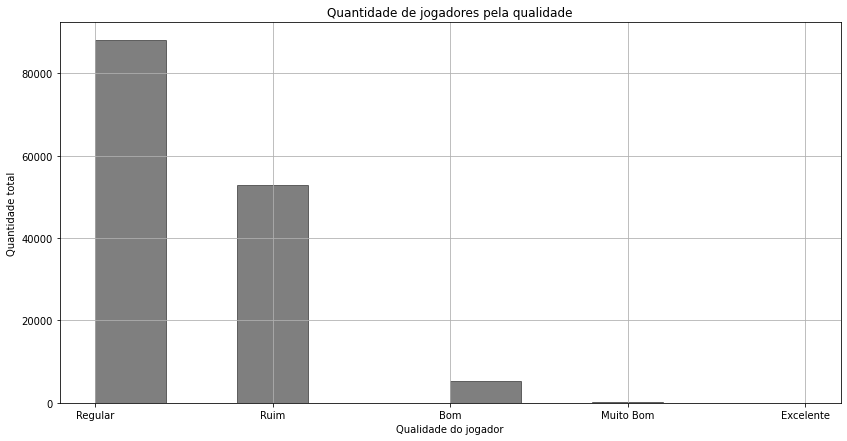

In [ ]:
plt.figure(figsize=(14, 7))
df_l['playerQuality'].hist( bins=10, ec = "k", alpha = .5, color = "black")
plt.ylabel('Quantidade total')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores pela qualidade')
plt.show()

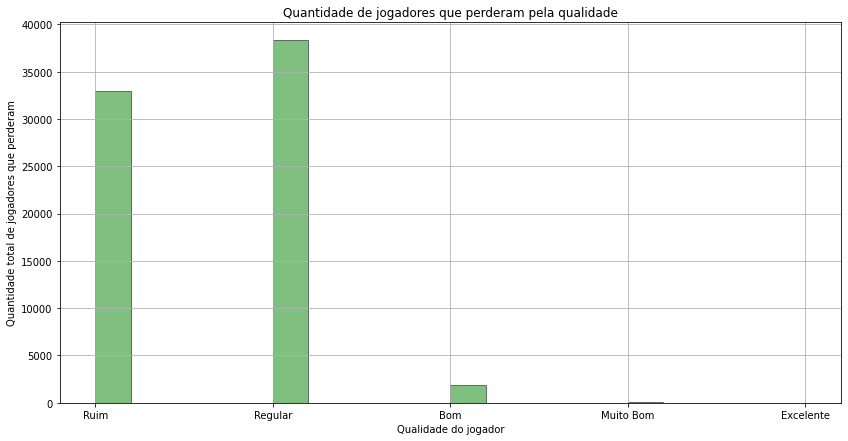

In [ ]:
plt.figure(figsize=(14, 7))
playersLosers = df_l[df_l["flWinner"]==0]
playersLosers['playerQuality'].hist( bins=20, ec = "k", alpha = .5, color = "green")
plt.ylabel('Quantidade total de jogadores que perderam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que perderam pela qualidade')
plt.show()

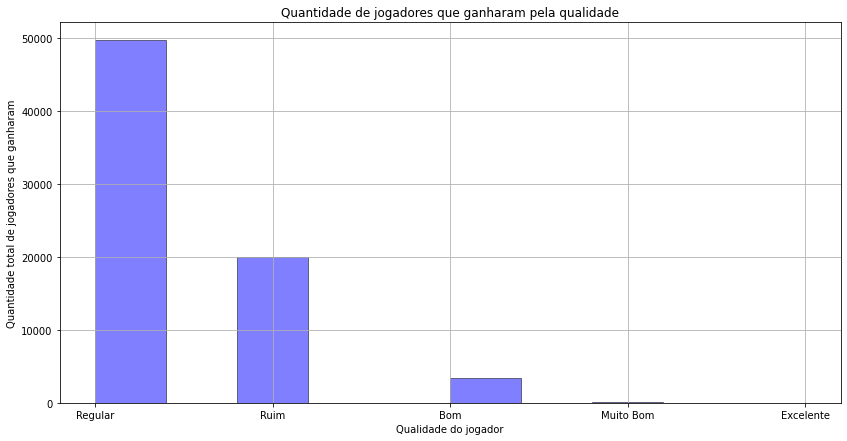

In [ ]:
plt.figure(figsize=(14, 7))
playersWinners = df_l[df_l["flWinner"]==1]
playersWinners['playerQuality'].hist( bins=10, ec = "k", alpha = .5, color = "blue")
plt.ylabel('Quantidade total de jogadores que ganharam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que ganharam pela qualidade')
plt.show()

Após uma vizualização de dados relacionados a vitória e a derrota através da qualidade do jogador pode-se concluir que como os dados estão pareados e não muito distantes. Dessa forma a qualidade do jogador não está relacionado a conclusão da partida (se o player perdeu ou ganhou)

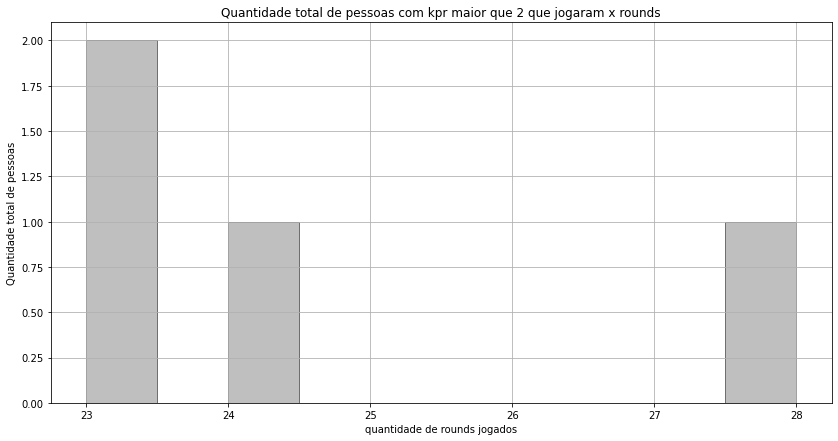

In [ ]:
plt.figure(figsize=(14, 7))
vg = df_l[df_l['kpr']>=2]
vg['qtRoundsPlayed'].hist( bins=10, ec = "k", alpha = .5, color = "gray")
plt.ylabel('Quantidade total de pessoas')
plt.xlabel('quantidade de rounds jogados')
plt.title('Quantidade total de pessoas com kpr maior que 2 que jogaram x rounds')
plt.show()

In [ ]:
vg['qtRoundsPlayed'].value_counts()

23    2
24    1
28    1
Name: qtRoundsPlayed, dtype: int64

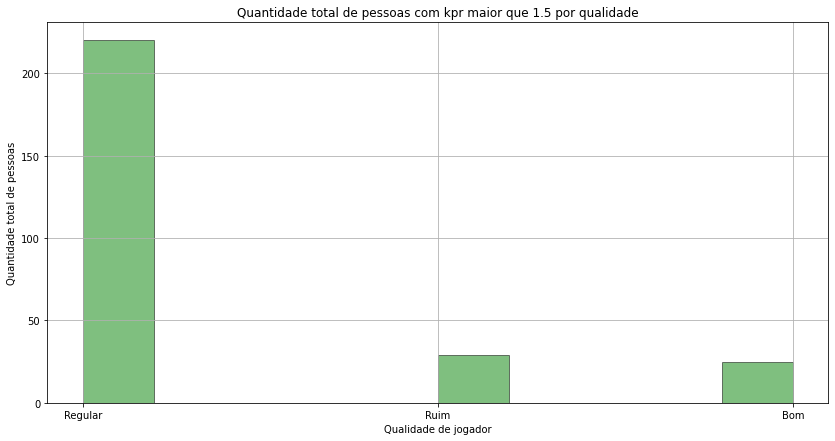

In [ ]:
plt.figure(figsize=(14, 7))
vg = df_l[df_l['kpr']>=1.5]
vg['playerQuality'].hist( bins=10, ec = "k", alpha = .5, color = "green")
plt.ylabel('Quantidade total de pessoas')
plt.xlabel('Qualidade de jogador')
plt.title('Quantidade total de pessoas com kpr maior que 1.5 por qualidade')
plt.show()

Players com Kpr alto estão entre 23 a 28 rounds jogados

In [ ]:
df_l['descMapName'].value_counts()

de_mirage      45887
de_inferno     33833
de_dust2       18753
de_vertigo     16001
de_nuke        11205
de_overpass    11151
de_train        6166
de_ancient      3385
Name: descMapName, dtype: int64

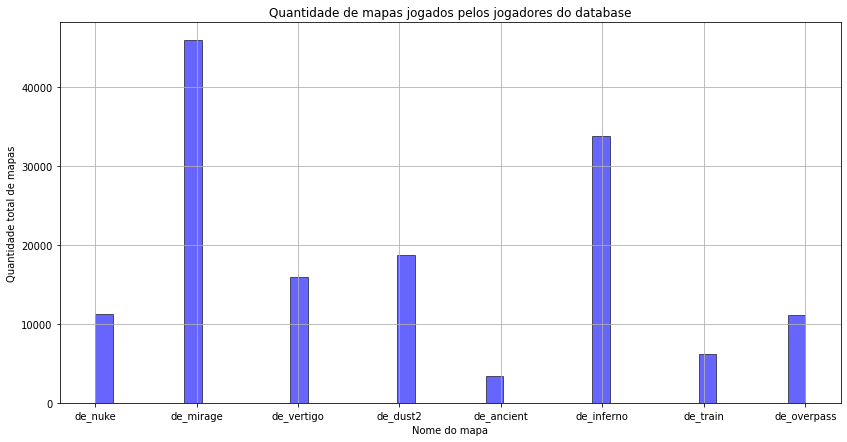

In [ ]:
plt.figure(figsize=(14, 7))
df_l['descMapName'].hist( bins=40, ec = "k", alpha = .6, color = "blue")
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores do database')
plt.show()

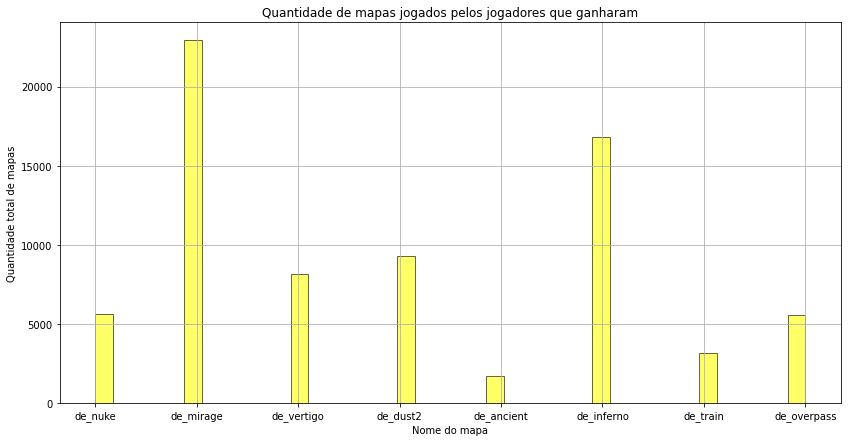

In [ ]:
plt.figure(figsize=(14, 7))
playersWinners['descMapName'].hist( bins=40, ec = "k", alpha = .6, color = "yellow")
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que ganharam')
plt.show()

In [ ]:
playersLosers['descMapName'].value_counts()

de_mirage      22971
de_inferno     17010
de_dust2        9481
de_vertigo      7873
de_overpass     5563
de_nuke         5559
de_train        2991
de_ancient      1698
Name: descMapName, dtype: int64

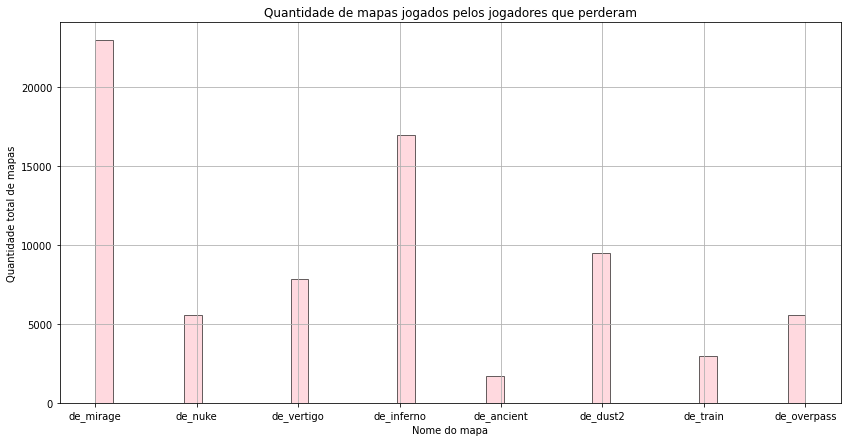

In [ ]:
plt.figure(figsize=(14, 7))
playersLosers['descMapName'].hist( bins=40, ec = "k", alpha = .6, color = "pink")
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que perderam')
plt.show()

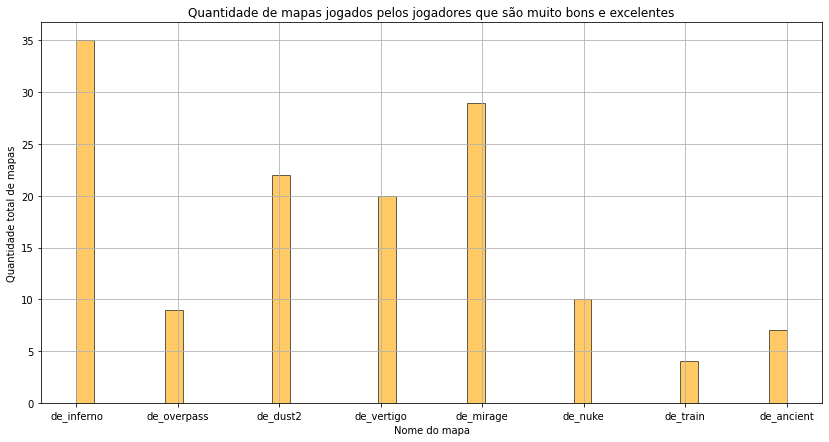

In [ ]:
plt.figure(figsize=(14, 7))
vgp = df_l[df_l['pps']>=60]
vgp['descMapName'].hist( bins=40, ec = "k", alpha = .6, color = "orange")
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que são muito bons e excelentes')
plt.show()
#jogadores com qualidade alta tendem a jogar mais inferno -> Over -> dust2 -> vertigo -> Mirage -> Nuke -> Train -> Ancient

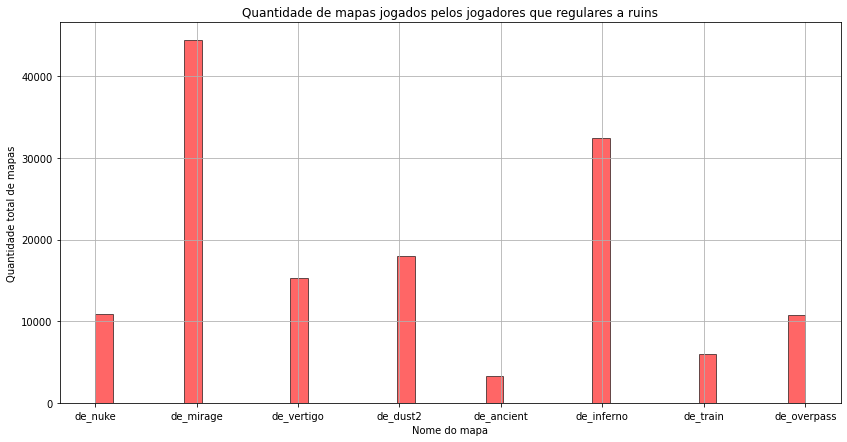

In [ ]:
plt.figure(figsize=(14, 7))
vgp = df_l[df_l['pps']<=40]
vgp['descMapName'].hist( bins=40, ec = "k", alpha = .6, color = "red")
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que regulares a ruins')
plt.show()

Os mapas mais jogados possuem players que perderam e possuem qualidade baixa.

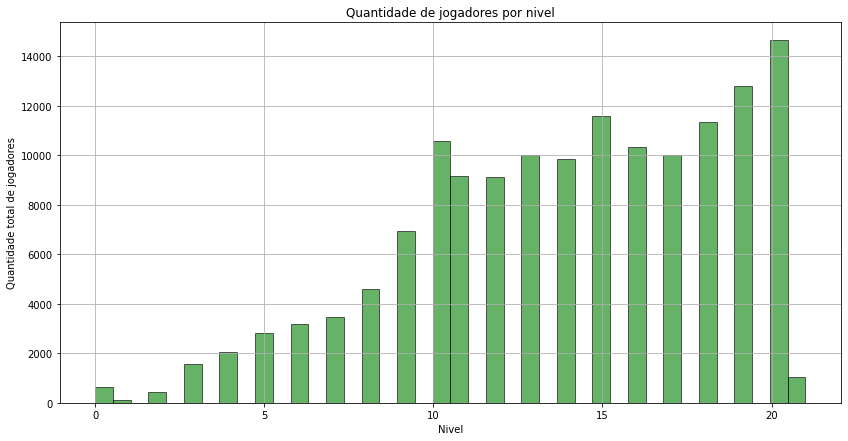

In [ ]:
plt.figure(figsize=(14, 7))
df_l['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "green")
plt.ylabel('Quantidade total de jogadores')
plt.xlabel('Nivel')
plt.title('Quantidade de jogadores por nivel')
plt.show()

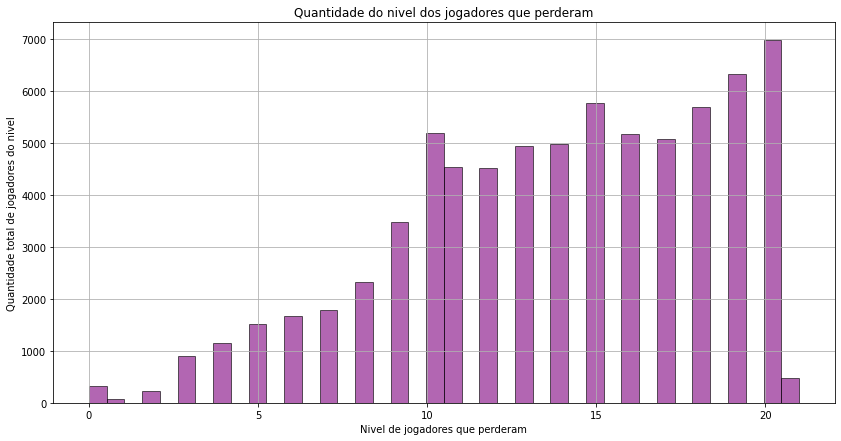

In [ ]:
plt.figure(figsize=(14, 7))
playersLosers['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "purple")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores que perderam')
plt.show()

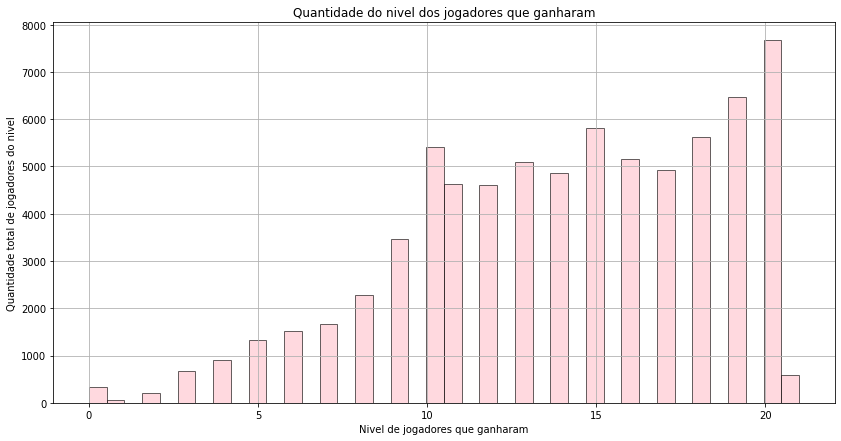

In [ ]:
plt.figure(figsize=(14, 7))
playersWinners['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "pink")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que ganharam')
plt.title('Quantidade do nivel dos jogadores que ganharam')
plt.show()

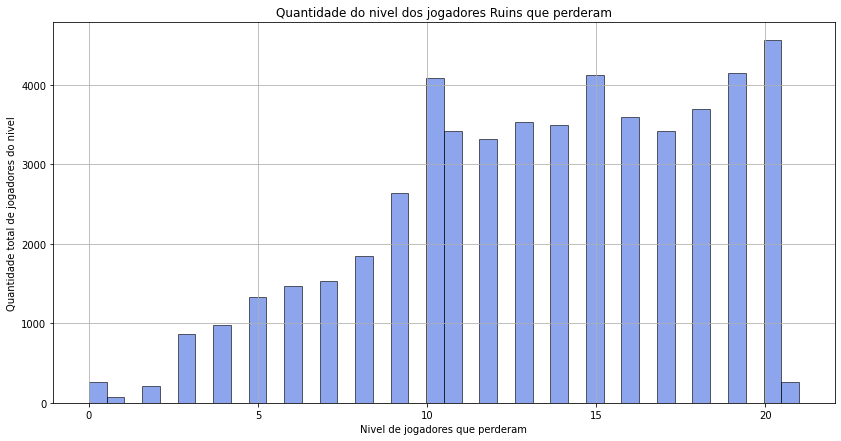

In [ ]:
plt.figure(figsize=(14, 7))
pqr = df_l[df_l["playerQuality"]=='Ruim']
ruim =pqr['vlLevel'].value_counts().unique()
pqr['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "royalblue")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Ruins que perderam')
plt.show()

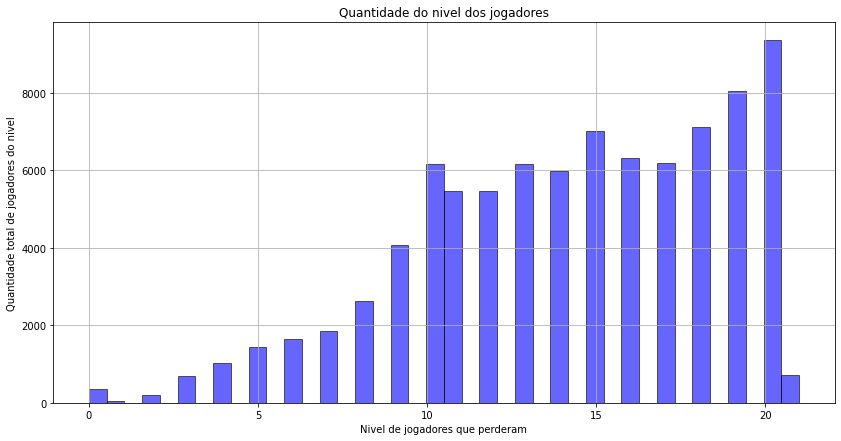

In [ ]:
plt.figure(figsize=(14, 7))
pqr = df_l[df_l["playerQuality"]=='Regular']
pqr['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "blue")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores')
plt.show()

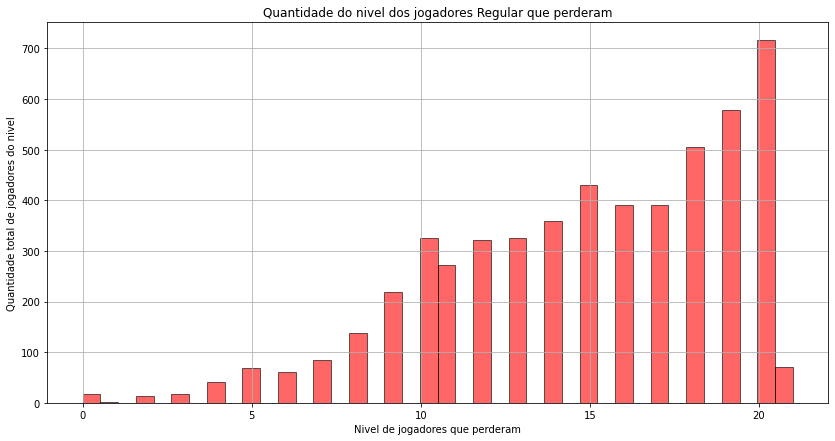

In [ ]:
plt.figure(figsize=(14, 7))
pqr = df_l[df_l["playerQuality"]=='Bom']
pqr['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "red")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regular que perderam')
plt.show()

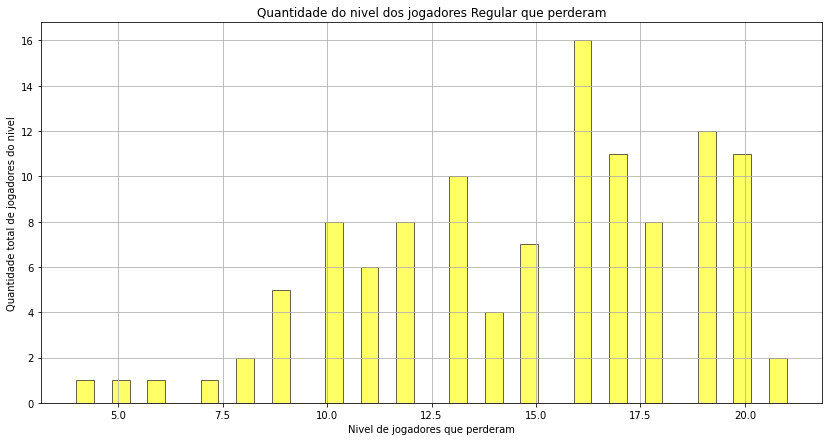

In [ ]:
plt.figure(figsize=(14, 7))
pqr = df_l[df_l["playerQuality"]=='Muito Bom']
pqr['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "yellow")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regular que perderam')
plt.show()

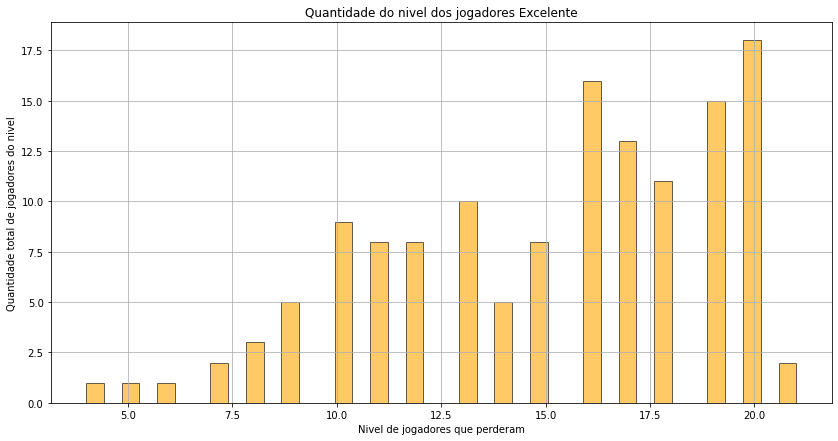

In [ ]:
plt.figure(figsize=(14, 7))
pqr = df_l[df_l["pps"]>=60]
pqr['vlLevel'].hist( bins=40, ec = "k", alpha = .6, color = "orange")
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Excelente')
plt.show()

**Após a avaliação de nivel por qualidade podemos ver que até os melhores niveis nao estao relacionados com a qualidade.**

In [ ]:
df_l['pps'].describe()

count    146381.000000
mean         23.866793
std           8.441445
min           0.000000
25%          17.857143
50%          22.857143
75%          29.285714
max          90.714286
Name: pps, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'kpr por mapa')

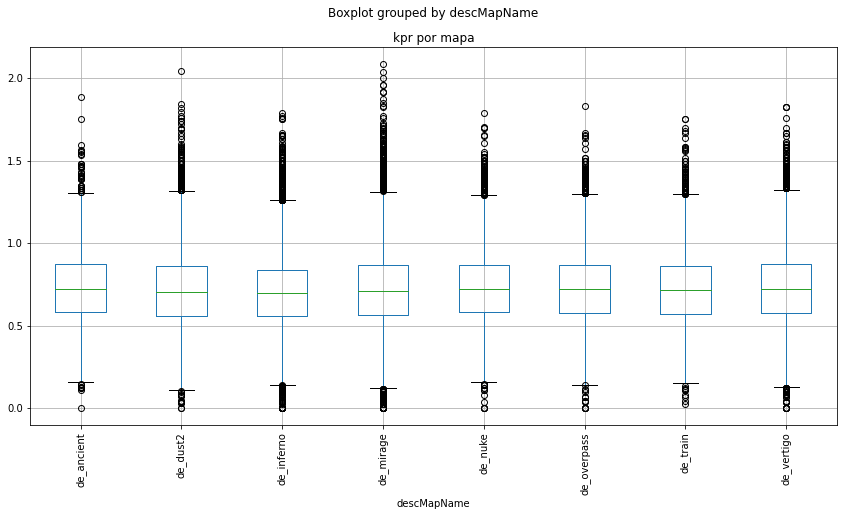

In [ ]:
killPorMapa = df_l.boxplot(column='kpr',by="descMapName", figsize=(14,7), rot =90)
killPorMapa.set_title("kpr por mapa")
#inconclusivo por enquanto, pois o mapa que tem mais kills também é o mapa mais jogado
#isso deve ser calculado com base na media de kills por partida 

In [ ]:
x = df_l.groupby('descMapName')
y = x['qtKill'].count()
x['qtKill'].describe()
#MEDIA DE KILLS POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3385.0,20.860561,7.156520,0.0,16.0,20.0,25.0,61.0
de_dust2,18753.0,20.383192,7.160521,0.0,15.0,20.0,25.0,85.0
de_inferno,33833.0,20.093843,6.846416,0.0,15.0,19.0,24.0,70.0
de_mirage,45887.0,20.548521,7.164227,0.0,16.0,20.0,25.0,73.0
de_nuke,11205.0,20.733244,7.000355,0.0,16.0,20.0,25.0,60.0
de_overpass,11151.0,20.739127,6.977826,0.0,16.0,20.0,25.0,67.0
de_train,6166.0,20.541356,7.107641,1.0,16.0,20.0,25.0,68.0
de_vertigo,16001.0,20.819761,7.142549,0.0,16.0,20.0,25.0,63.0


In [ ]:
x = df_l.groupby('descMapName')
y = x['qtClutchWon'].count()
x['qtClutchWon'].describe()
#MEDIA DE CLUTCH POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3385.0,0.536780,0.757092,0.0,0.0,0.0,1.0,6.0
de_dust2,18753.0,0.501786,0.733980,0.0,0.0,0.0,1.0,5.0
de_inferno,33833.0,0.473827,0.711546,0.0,0.0,0.0,1.0,8.0
de_mirage,45887.0,0.501602,0.731685,0.0,0.0,0.0,1.0,6.0
de_nuke,11205.0,0.535475,0.763382,0.0,0.0,0.0,1.0,7.0
de_overpass,11151.0,0.525065,0.748256,0.0,0.0,0.0,1.0,6.0
de_train,6166.0,0.513623,0.739167,0.0,0.0,0.0,1.0,5.0
de_vertigo,16001.0,0.544653,0.766092,0.0,0.0,0.0,1.0,8.0


In [ ]:
x = df_l.groupby('descMapName')
y = x['kpr'].count()
x['kpr'].describe()

#MEDIA DE KPR POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3385.0,0.733093,0.222625,0.000000,0.583333,0.720000,0.872340,1.888889
de_dust2,18753.0,0.719242,0.225617,0.000000,0.560000,0.703704,0.862069,2.043478
de_inferno,33833.0,0.707770,0.215346,0.000000,0.560000,0.695652,0.840000,1.791667
de_mirage,45887.0,0.725310,0.226072,0.000000,0.566667,0.708333,0.866667,2.083333
de_nuke,11205.0,0.730903,0.219040,0.000000,0.583333,0.720000,0.866667,1.791667
de_overpass,11151.0,0.729663,0.217308,0.000000,0.576923,0.720000,0.866667,1.833333
de_train,6166.0,0.725927,0.223992,0.027778,0.571429,0.714286,0.862069,1.750000
de_vertigo,16001.0,0.734103,0.222906,0.000000,0.576923,0.722222,0.875000,1.827586


In [ ]:
kill = df_l.qtKill.sum() #quantidade de kills do DataBase
flash = df_l.qtFlashAssist.sum()

flash/kill #porcentagem de kills que tiveram auxilio de flashs
#aproximadamente 2% das kills apenas tem assistencia de flashs

0.029936208247012232

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Kpr por qualidade de player')

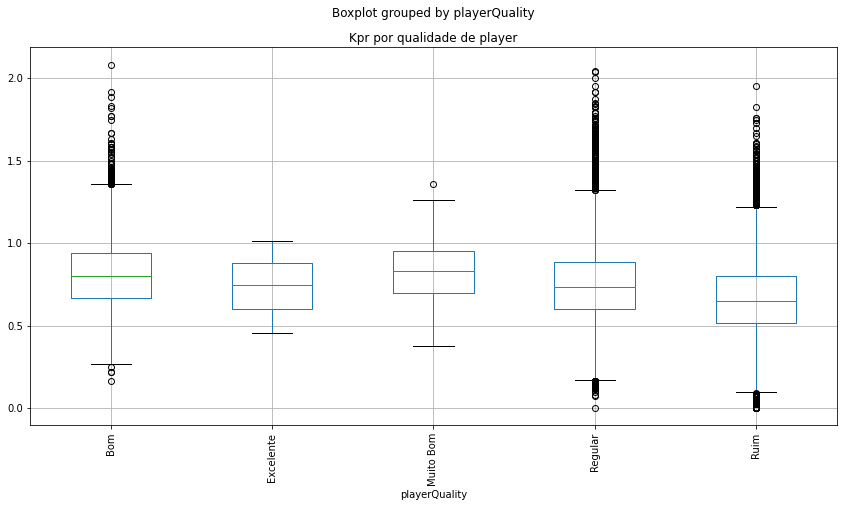

In [ ]:
killPorQualidade = df_l.boxplot(column='kpr',by="playerQuality", figsize=(14,7), rot =90)
killPorQualidade.set_title("Kpr por qualidade de player")

In [ ]:
win = df_l['flWinner']>0
win.value_counts()

True     73235
False    73146
Name: flWinner, dtype: int64

In [ ]:
df_l['qtSurvived']

1          8.0
2          2.0
3          3.0
4          4.0
11         6.0
          ... 
184146     9.0
184147    11.0
184148     7.0
184149     4.0
184150     5.0
Name: qtSurvived, Length: 146381, dtype: object

In [ ]:
a = df_l[['dpr', 'qtSurvived']]
a.corr()

,dpr
dpr,1.0


In [ ]:
b = df_l[['vlDamage', 'qtKill']]
b.corr()

,vlDamage,qtKill
vlDamage,1.000000,0.948231
qtKill,0.948231,1.000000


In [ ]:
#regras de associação
#kpr < 0.5 - ruim, Kpr>=0.5 < 1.0 - regular, 1-1.3 bom; 1.3-1.5 - muito bom; 1.5 - excelente
bins = [0, 0.5, 1, 1.3, 1.5, np.inf]
names = ['Ruim', 'Regular', 'Bom', 'Muito Bom', 'Excelente']
df_l['kpr_categoric'] = pd.cut(df_l['kpr'], bins, labels=names)

In [ ]:
#dpr 0:0.2 - Excelente, 0.2:0.4 - Muito bom, 0.4:0.6 - Bom; 0.6:0.8 - Regular; 0.8 - Ruim
bins = [0, 0.2, 0.4, 0.6, 0.8, np.inf]
names = ['Excelente', 'Muito Bom', 'Bom', 'Regular', 'Ruim']
df_l['dpr_categoric'] = pd.cut(df_l['dpr'], bins, labels=names)

In [ ]:
df_l

,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qt1Kill,qt2Kill,qt3Kill,qt4Kill,...,qtTrade,qtFlashAssist,flWinner,kpr,dpr,pps,playerQuality,dM50,kpr_categoric,dpr_categoric
1,24,3,18,6,0,4,9,4,1,1,...,1.0,0.0,1,0.888889,0.666667,23.571429,Regular,0,Regular,Regular
2,6,4,23,2,0,1,4,1,0,0,...,3.0,0.0,0,0.240000,0.920000,17.857143,Ruim,0,Ruim,Ruim
3,10,5,20,4,1,0,6,2,0,0,...,4.0,0.0,1,0.400000,0.800000,23.571429,Regular,0,Ruim,Regular
4,8,4,26,6,0,2,4,2,0,0,...,4.0,2.0,0,0.266667,0.866667,22.857143,Regular,0,Ruim,Ruim
11,19,2,21,7,0,0,9,5,0,0,...,3.0,3.0,0,0.703704,0.777778,18.571429,Ruim,0,Regular,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184146,17,3,19,7,0,2,12,1,1,0,...,4.0,0.0,0,0.607143,0.678571,20.714286,Regular,0,Regular,Regular
184147,21,3,13,5,1,1,8,5,1,0,...,0.0,0.0,1,0.807692,0.500000,15.714286,Ruim,1,Regular,Bom
184148,15,1,22,5,0,1,11,2,0,0,...,5.0,0.0,1,0.517241,0.758621,18.571429,Ruim,0,Regular,Regular
184149,9,6,23,2,0,3,9,0,0,0,...,2.0,0.0,0,0.333333,0.851852,25.000000,Regular,0,Ruim,Ruim


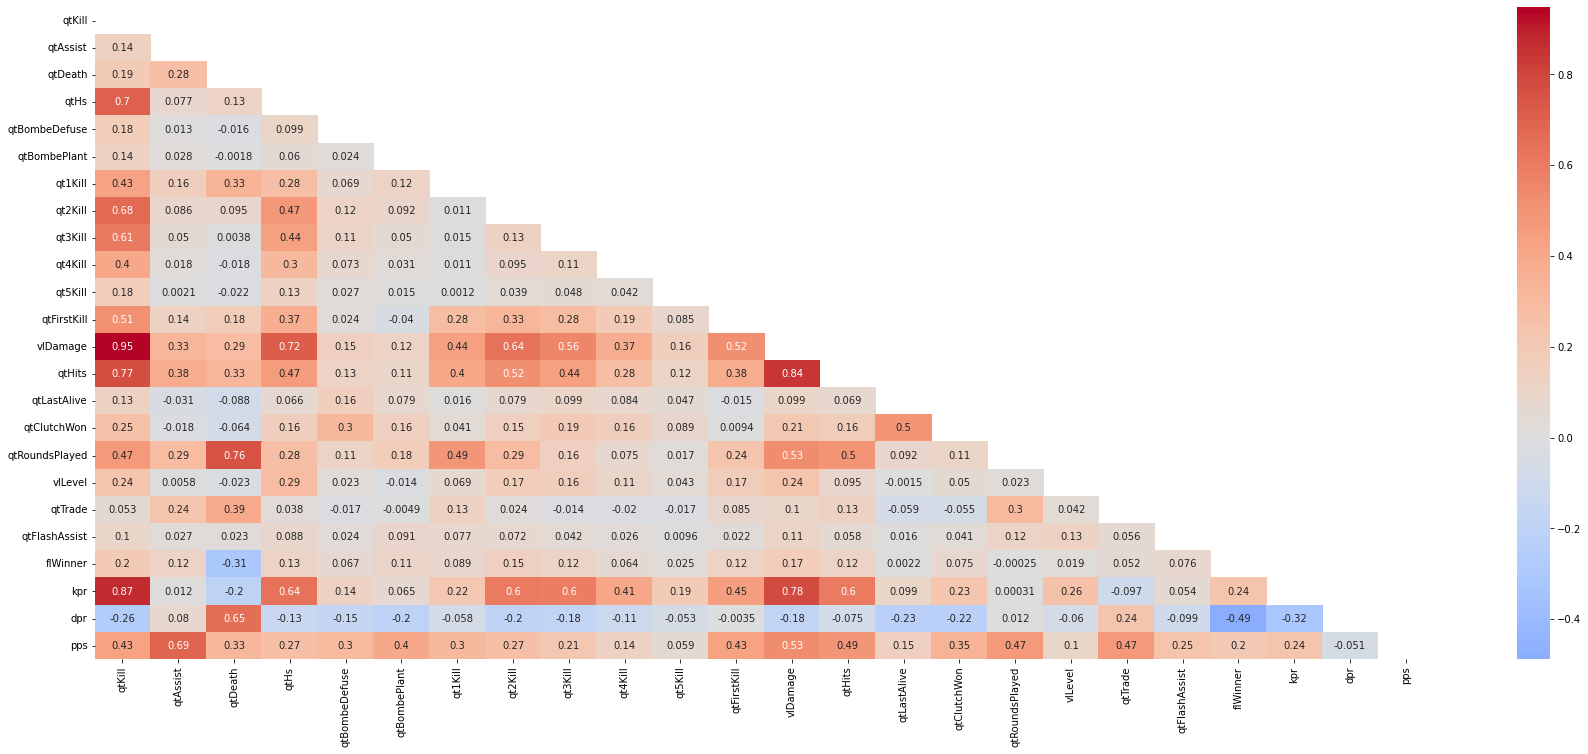

In [ ]:
Var_Corr = df_l.corr()
matrix = np.triu(df_l.corr())

plt.figure(figsize = (30,12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns,\
            annot=True,center= 0, cmap= 'coolwarm',mask=matrix)

Pode-se ver pelos dados que temos valores com relações altas, como exemplo o dpr e flwinner, eles são inversamente proporcionais, qtHits com phs, vlDamage e qtKill. Dessa forma podemos perceber que os valores numéricos realmente estão ligados através do heat map, dessa forma aplicar clusterização podemos ter uma forma melhor de agrupamento de dados. Porém seria interessante também observar se os valores categóricos podem nos aplicar alguma sentença

In [ ]:
df_rules = df_l[['kpr_categoric','dpr_categoric','playerQuality','descMapName', 'flWinner', 'dM50']]
df_rules.head()

,kpr_categoric,dpr_categoric,playerQuality,descMapName,flWinner,dM50
1,Regular,Regular,Regular,de_nuke,1,0
2,Ruim,Ruim,Ruim,de_mirage,0,0
3,Ruim,Regular,Regular,de_mirage,1,0
4,Ruim,Ruim,Regular,de_nuke,0,0
11,Regular,Regular,Ruim,de_mirage,0,0


In [ ]:
df_transactions = pd.get_dummies(df_rules)
#df_transactions = df_rules
#df_transactions = pd.get_dummies(df_transactions, columns=['kpr_categoric'])
#df_transactions = pd.get_dummies(df_transactions, columns=['dpr_categoric'])
#df_transactions = pd.get_dummies(df_transactions, columns=['playerQuality'])
#df_transactions = pd.get_dummies(df_transactions, columns=['descMapName'])

In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 1 to 184150
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   flWinner                 146381 non-null  int64
 1   kpr_categoric_Ruim       146381 non-null  uint8
 2   kpr_categoric_Regular    146381 non-null  uint8
 3   kpr_categoric_Bom        146381 non-null  uint8
 4   kpr_categoric_Muito Bom  146381 non-null  uint8
 5   kpr_categoric_Excelente  146381 non-null  uint8
 6   dpr_categoric_Excelente  146381 non-null  uint8
 7   dpr_categoric_Muito Bom  146381 non-null  uint8
 8   dpr_categoric_Bom        146381 non-null  uint8
 9   dpr_categoric_Regular    146381 non-null  uint8
 10  dpr_categoric_Ruim       146381 non-null  uint8
 11  playerQuality_Bom        146381 non-null  uint8
 12  playerQuality_Excelente  146381 non-null  uint8
 13  playerQuality_Muito Bom  146381 non-null  uint8
 14  playerQuality_Regular    146381 non-

In [ ]:
#Erro pois não tem apenas 0 ou 1
frequent_itemsets = apriori(df_transactions, min_support=0.3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.500304,(flWinner)
1,0.740356,(kpr_categoric_Regular)
2,0.673837,(dpr_categoric_Regular)
3,0.601205,(playerQuality_Regular)
4,0.361454,(playerQuality_Ruim)
5,0.313476,(descMapName_de_mirage)
6,0.969033,(dM50_0)
7,0.378341,"(flWinner, kpr_categoric_Regular)"
8,0.342066,"(flWinner, dpr_categoric_Regular)"
9,0.339559,"(playerQuality_Regular, flWinner)"


In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules.sort_values(by="confidence",ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
61,"(playerQuality_Regular, dpr_categoric_Regular)",(dM50_0),0.418675,0.969033,0.418675,1.0,1.031957,0.012965,inf
17,(dpr_categoric_Regular),(dM50_0),0.673837,0.969033,0.673837,1.0,1.031957,0.020867,inf
49,"(kpr_categoric_Regular, dpr_categoric_Regular)",(dM50_0),0.518510,0.969033,0.518510,1.0,1.031957,0.016057,inf
31,"(flWinner, dpr_categoric_Regular)",(dM50_0),0.342066,0.969033,0.342066,1.0,1.031957,0.010593,inf
67,"(playerQuality_Regular, kpr_categoric_Regular,...",(dM50_0),0.328335,0.969033,0.328335,1.0,1.031957,0.010168,inf


In [ ]:
cols_interesse = ['kpr_categoric_Ruim','kpr_categoric_Regular','kpr_categoric_Bom','kpr_categoric_Muito Bom','kpr_categoric_Excelente  ',
                  'dpr_categoric_Ruim','dpr_categoric_Regular','dpr_categoric_Bom','dpr_categoric_Muito Bom','dpr_categoric_Excelente  ',
                  'playerQuality_Bom', 'playerQuality_Muito Bom', 'playerQuality_Regular', 'playerQuality_Ruim', 'playerQuality_Excelente',
                  'descMapName_de_ancient', 'descMapName_de_dust2', 'descMapName_de_inferno', 'descMapName_de_mirage', 'descMapName_de_nuke',
                  'descMapName_de_overpass', 'descMapName_de_train', 'descMapName_de_vertigo'
                  ]


In [ ]:
df = pd.get_dummies(df_l, columns=["playerQuality"])

In [ ]:
cols_interesse = ['qtKill','qtDeath','vlDamage','qtClutchWon','vlLevel','qtHs','qt5Kill','kpr','dpr','pps','playerQuality_Bom','playerQuality_Excelente','playerQuality_Muito Bom','playerQuality_Regular','playerQuality_Ruim']
target = 'flWinner'

In [ ]:
cols_interesse_all = cols_interesse.copy()
cols_interesse_all.append(target)

In [ ]:
df['dpr']

1         0.666667
2         0.920000
3         0.800000
4         0.866667
11        0.777778
            ...   
184146    0.678571
184147    0.500000
184148    0.758621
184149    0.851852
184150    0.800000
Name: dpr, Length: 146381, dtype: float64

In [ ]:
 df[target]

1         1
2         0
3         1
4         0
11        0
         ..
184146    0
184147    1
184148    1
184149    0
184150    0
Name: flWinner, Length: 146381, dtype: int64

Coeficiente estimado:  [-2.3578828]
R2 (score):  0.2385279990828909
Intercept 2.176 
     Coefficient
dpr    -2.357883
Estimated coefficients:
b_0 = 2.176360849058079 nb_1 = -2.3578827975859444


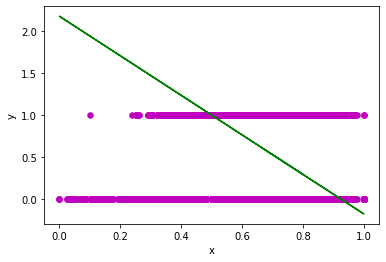

In [ ]:
X = df['dpr']
Y = df[target]
regressao_linear(X,Y,['dpr'])

b = estimate_coef(df['dpr'],df[target]) 
print("Estimated coefficients:\nb_0 = {} nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(df['dpr'], df[target], b)

Coeficiente estimado:  [0.00021285]
R2 (score):  0.6126123877692518
Intercept 0.151 
          Coefficient
vlDamage     0.000213
Estimated coefficients:
b_0 = 0.15149043005522767 nb_1 = 0.0002128501109631428


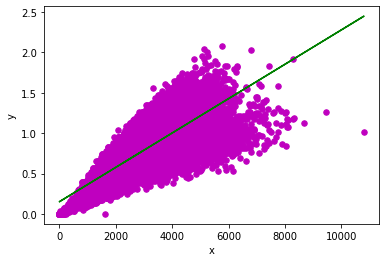

In [ ]:
X = df['vlDamage']
Y = df['kpr']
regressao_linear(X,Y,['vlDamage'])

b = estimate_coef(df['vlDamage'],df['kpr']) 
print("Estimated coefficients:\nb_0 = {} nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(df['vlDamage'], df['kpr'], b)

Coeficiente estimado:  [0.02221618]
R2 (score):  0.7124853051191407
Intercept 9.194 
          Coefficient
vlDamage     0.022216
Estimated coefficients:
b_0 = 9.193852470585611 nb_1 = 0.022216182289922067


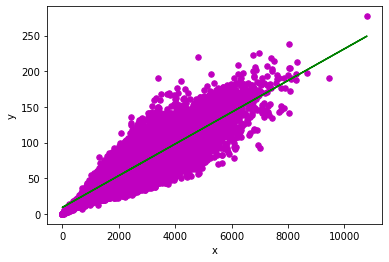

In [ ]:
X = df['vlDamage']
Y = df['qtHits']
regressao_linear(X,Y,['vlDamage'])

b = estimate_coef(df['vlDamage'],df['qtHits']) 
print("Estimated coefficients:\nb_0 = {} nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(df['vlDamage'], df['qtHits'], b)

Previsão

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

def classifier(X_train,X_test,Y_train,Y_test):
    #Aplicando KNN
    print(" KNN ")
    ini = time.time() #Inicio do calculo do tempo

    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    end = time.time()
    knn_time = end - ini # Fim do calculo do tempo

    print(classification_report(Y_test,knn.predict(X_test)))
    print(confusion_matrix(Y_test, knn.predict(X_test)))
    print()
    
    #Aplicando Arvore de Decisao
    print("Árvore de Decisão")
    ini = time.time() #Inicio do calculo do tempo

    dtc=tree.DecisionTreeClassifier()
    dtc.fit(X_train,Y_train)

    end = time.time()
    dtc_time = end - ini # Fim do calculo do tempo

    print(classification_report(Y_test,dtc.predict(X_test)))
    print(confusion_matrix(Y_test, dtc.predict(X_test)))
    print(dtc_time)
    print(knn_time)

In [ ]:
df['dM50'].unique()

array([0, 1], dtype=object)

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(df['dM50'],df['flWinner'],test_size=0.3, random_state=5)

In [ ]:
classifier(X_train.values.reshape(-1, 1),X_test.values.reshape(-1, 1),Y_train,Y_test)

 KNN 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21848
           1       0.50      1.00      0.67     22067

    accuracy                           0.50     43915
   macro avg       0.25      0.50      0.33     43915
weighted avg       0.25      0.50      0.34     43915

[[    0 21848]
 [    0 22067]]

Árvore de Decisão
              precision    recall  f1-score   support

           0       0.51      0.99      0.67     21848
           1       0.90      0.06      0.10     22067

    accuracy                           0.52     43915
   macro avg       0.70      0.52      0.39     43915
weighted avg       0.71      0.52      0.39     43915

[[21711   137]
 [20840  1227]]
0.015163421630859375
0.03994393348693848


Clusterização

In [ ]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 1 to 184150
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   qtKill          146381 non-null  int64   
 1   qtAssist        146381 non-null  int64   
 2   qtDeath         146381 non-null  int64   
 3   qtHs            146381 non-null  int64   
 4   qtBombeDefuse   146381 non-null  int64   
 5   qtBombePlant    146381 non-null  int64   
 6   qt1Kill         146381 non-null  int64   
 7   qt2Kill         146381 non-null  int64   
 8   qt3Kill         146381 non-null  int64   
 9   qt4Kill         146381 non-null  int64   
 10  qt5Kill         146381 non-null  int64   
 11  qtFirstKill     146381 non-null  int64   
 12  vlDamage        146381 non-null  int64   
 13  qtHits          146381 non-null  float64 
 14  qtLastAlive     146381 non-null  float64 
 15  qtClutchWon     146381 non-null  int64   
 16  qtRoundsPlayed  146381 non-null  int64

In [ ]:
cols_interesse = ['qt1Kill','qt2Kill','qt3Kill','qt4Kill','qt5Kill','qtFirstKill',
                  'vlDamage','qtHits', 'qtLastAlive', 'qtClutchWon','vlLevel','qtSurvived','qtTrade','qtFlashAssist','flWinner','kpr','dpr','pps']
df[cols_interesse]

,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtFirstKill,vlDamage,qtHits,qtLastAlive,qtClutchWon,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr,pps
1,9,4,1,1,0,3,2933,54.0,1.0,1,9,8.0,1.0,0.0,1,0.888889,0.666667,23.571429
2,4,1,0,0,0,2,1117,31.0,0.0,0,2,2.0,3.0,0.0,0,0.240000,0.920000,17.857143
3,6,2,0,0,0,1,1740,63.0,1.0,1,15,3.0,4.0,0.0,1,0.400000,0.800000,23.571429
4,4,2,0,0,0,1,1696,51.0,0.0,0,2,4.0,4.0,2.0,0,0.266667,0.866667,22.857143
11,9,5,0,0,0,4,2459,55.0,0.0,0,2,6.0,3.0,3.0,0,0.703704,0.777778,18.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184146,12,1,1,0,0,3,2179,63.0,0.0,0,9,9.0,4.0,0.0,0,0.607143,0.678571,20.714286
184147,8,5,1,0,0,3,2610,88.0,1.0,0,9,11.0,0.0,0.0,1,0.807692,0.500000,15.714286
184148,11,2,0,0,0,5,2154,63.0,0.0,0,9,7.0,5.0,0.0,1,0.517241,0.758621,18.571429
184149,9,0,0,0,0,2,1701,59.0,0.0,0,9,4.0,2.0,0.0,0,0.333333,0.851852,25.000000


In [ ]:
def plot_cluster(model, df, attr_x, attr_y):
  plt.figure(figsize=(15,9))
  sns.scatterplot(x=df[attr_x], y=df[attr_y], hue=model.labels_, s=40)
  plt.title('Classificação K-Means') 
    
  plt.show()

Definir numero de clusters através do coeficiente da silhueta

In [ ]:
from sklearn import metrics

In [ ]:
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(df[cols_interesse])
labels = kmeans_model.labels_
metrics.silhouette_score(df[cols_interesse], labels, metric='euclidean')

0.5564993927070536

In [ ]:

plot_cluster(kmeans_model, df_l, "dpr","flWinner")
plot_cluster(kmeans_model, df_l, "vlDamage","kpr")
plot_cluster(kmeans_model, df_l, "vlDamage","pps")
plot_cluster(kmeans_model, df_l, "vlDamage","dpr")
plot_cluster(kmeans_model, df_l, "vlDamage","qtHits")

Após todas essas analises podemos retornar as perguntas que propusemos para o começo do trabalho.

**1) É possível separar os jogadores por categorias??**

Sim podemos separar os jogadores em categorias, se levarmos em conta alguns atributos como o pps criado pelo grupo (Points per status), que leva em conta assistencias, bomba plantada e defusada, clutchs vencidos, Trade Kills, assistências com Flash, e First kills, podemos dividir os jogadores em 5 categorias,

Ruim: Onde pps é menor que 20

Regular: Onde pps está entre 21 e 40

Bom: onde pps está entre 41 e 60

Otimo: onde pps está entre 61 e 80

Excelente: onde pps está entre 81 e 100

**2)É possível conhecer os jogadores que tiveram o melhor desempenho**

Sim é exatamente isso que nossa variavel pps avalia, ela julga os jogadores com base em status que mais importam dentro de uma partida competitiva de CS-GO

**3)Quais são os mapas mais jogados?**

os mapas mais jogados são na ordem:

Mirage, Inferno, Dust 2, Vertigo, Nuke, Overpass, Train e Ancient.

Onde Mirage representa aproximadamente 31,34% das partidas

de_mirage 45887 de_inferno 33833 de_dust2 18753 de_vertigo 16001 de_nuke 11205 de_overpass 11151 de_train 6166 de_ancient 3385

**4)Qual mapa as pessoas mais perdem?**

O mapa que as pessoas mais perdem é Mirage pois é o mapa mais jogado

**5)Quais mapas os jogadores mais ganham?**

O mapa que as pessoas mais ganham é Mirage pois é o mapa mais jogado

**6)Qual mapa os jogadores têm mais desempenho?**

Os mapas que os jogadores melhor desempenham envolve os mapas onde o kpr são maiores, são eles: Mirage, Inferno e Dust 2

**7)Os níveis dizem muito sobre os jogadores?**

Sim os niveis refletem bem os jogadores, os jogadores de niveis intermediarios perdem e ganham aproximadamente o mesmo tanto, os jogadores de nivel 0 são incógnitas pois, podem ser jogadores "Ruins" ou jogadores novos , e os jogadores de niveis entre 1- 5 são os que mais perdem

**8)Quais níveis têm os jogadores com melhor desempenho?**

Considerando melhor desempenho como vitórias, os jogadores de nivel 20, 10 e 15 são os que possuem os melhores, curiosamente, os jogadores de nivel 20 são os mais comuns, os de nivel 15 são os 3º e os de nivel 10 os 5º.

**9)É possível prever quais jogadores têm mais qualidade?**

**10)É possível prever quem ganhou?**
Sim, com 

**11)Quais são os atributos de maior peso para um jogador??**


**12)Quais os fatores que determinam sua vitória?**
Basicamente os fatores que determinam a vitória são, quantidade de kills, mortes, clutchs vencidos, a categorização do player, o level, kpr pps e dpr, são as variaveis usadas para medir a chance de vitória do jogador 


**13)Os mapas possuem padrões de jogadores?**

Sim, porém sutis, se você jogar um mapa inferno provavelmente encontrará jogadores melhores, se jogar mirage, a chance é de que encontre um jogador mediano ou inferior.

**14)Como podemos medir a qualidade de um jogador?**
Podemos medir a qualidade de um jogador através de analise da variavel pps, ela engloba todos os fatores que o auxiliam a ganhar um round e por consequencia ganhar o mapa, coisas como quantidade de kills, bombas plantadas e defusadas por exemplo são fatores que ganham a rodada, uma bomba defusada é com certeza um round ganho pelo jogador. 

**15)É possivel saber quais jogadores desempenharam papeis mais importantes durante o jogo?**

Sim, olhando variáveis especificas dentro do escopo do jogador como por exemplo FirstKills e dpr podemos dizer se esse jogador cumpriu o papel de "Entry fragger" do time, que é o jogador que se arrisca primeiro para ganhar espaço para o time, o entry fragger normalmente tem uma alta taxa de firstKills, uma alta taxa de mortes pois ele morre depois de matar, e uma alta taxa de dpr, pois normalmente ele mata o primeiro jogador e inflige dano a outro.

**16)É possivel prever jogadores que possuem um função?**

Sim, no CS-GO existem algumas funções especificas são elas:

AWPer: o jogador que joga com a arma AWP, um rifle de precisão tão caro quanto letal, exige paciencia do jogador que não pode morrer cedo já que normalmente possui o equipamento mais caro do time, a arma elimina com apenas um tiro no corpo e na cabeça e inflige dano não letal nas pernas, AWPers tendem a ter uma baixa taxa de mortes, um alto dano (visto que caso acerte a cabeça de um jogador o dano é 4 vezes o dano necessário para eliminação [100])

EntryFragger: como descrito anteriormente, o jogador que se expoem mais para ajudar o seu time a ganhar espaço, normalmente possui uma alta taxa de mortes e uma alta taxa de FirstKill.

ShotCaller/inGameLeader: esta função infelizmente não podemos prever com nossos dados, mas é o jogador que vai coordenar o time e vaai dizer o que cada um tem que fazer para que o time não fique perdido, é possivel através da quantidade de vitórias do jogador dizer se ele é um bom inGameLeader, mas não podemos dizer se ele é um inGameLeader atualmente.

Support: suportes são os jogadores que mais auxiliam no jogo, não são tão focados em mira, mas sim em granadas, quantidade de flashAssists, tradeKills, Assists, dpr/kpr (dano dividido por kill no round, já que ele joga muito com granadas, ele normalmente não mata muito, mas inflige bastante dano com elas).

Lurker: São os jogadores que olham as costas do time normalmente, esses jogadores sobrevivem bastante, tem uma baixa taxa de mortes pois jogam depois que seu time começou a se mover, eliminando inimigos mudando de posição, por jogar depois do próprio time, o que mais difere esse jogador dos outros é a quantidade de clutchWons, clutchs vencidos já que ele tende a ser o ultimo jogador vivo do time.

Entre outras funções secundárias

**17)É possivel prever todas as funções de um time?**

  Como mencionado antes, infelizmente não, inGameLeader não pode ser previsto, no entanto podemos prever uma grande maioria das funções.

**18)Pode-se associar categorias de jogadores devido ao desempenhos?**

Sim, jogadores considerados Ruins tendem a perder mais partidas, entretanto, como explicado antes o jogador Ruim não necessariamente é um mal jogador, ele apenas não possui um bom valor nos parametros que analisamos, ele pode ser um ótimo inGameLeader e ser considerado Ruim.

**19)É possivel saber o potencial dos jogadores?**

--

**20)Jogadores com potenciais menores podem ter matado mais que jogadores com potenciais maiores?**

Sim, isso não é limitador, a tendencia é que jogadores com potencial maior eliminem mais jogadores que o de potencial menor, porém como explicado pelo boxplot acima, existe sim a possibilidade que um jogador considerado Ruim elimine mais que um Bom, e é perfeitamente comum